<a href="https://colab.research.google.com/github/barauna-lo/Code_Library/blob/main/Astronomical_UNet_GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://jwuphysics.substack.com/p/gans

In [ ]:
!pip uninstall torch -y
# CUDA 10.1
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fastai==2.0.19
!pip install fastcore==1.3.1

!wget http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

Uninstalling torch-1.7.0+cu101:
  Successfully uninstalled torch-1.7.0+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 24kB/s 
     |████████████████████████████████| 5.9MB 65.9MB/s 
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 194kB 17.2MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 51kB 7.5MB/s 
  Found existing installation: fastcore 1.3.18
    Uninstalling fastcore-1.3.18:
      Successfully uninstalled fastcore-1.3.18
--2021-01-11 21:09:01--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (a

In [ ]:
from fastai.basics import *
from fastai.vision.all import *

import h5py
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with h5py.File('Galaxy10.h5', 'r') as f:
    images = np.array(f['images'])
    labels = np.array(f['ans'])

# Set up Low and high-resolution data for GAN

In [ ]:
from fastai.vision.gan import *
from skimage.util import random_noise
from skimage.transform import rescale, resize, downscale_local_mean
from tqdm import tqdm
from IPython.display import display

In [ ]:
!mkdir lowres
!mkdir original

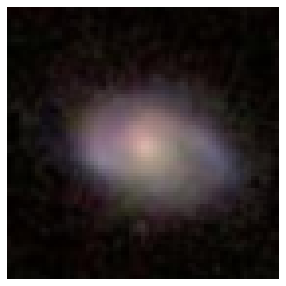

In [ ]:
im = PILImage.create(images[52])
im.show(figsize=(5,5))

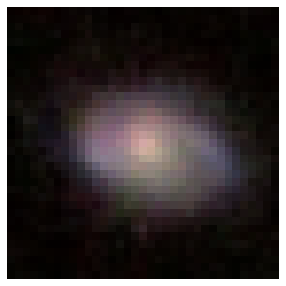

In [ ]:
# noisy = downscale_local_mean(images[52], (2, 2, 1)).astype(np.uint8)
noisy = resize(images[52], (35, 35), anti_aliasing=True)
noisy = random_noise(noisy, mode='poisson')
noisy = np.array(255 * noisy, dtype=np.uint8)
PILImage.create(noisy).show(figsize=(5,5))

In [ ]:
for idx, [image, label] in tqdm(enumerate(zip(images, labels)), total=len(images)):
    im = Image.fromarray(image)

    # original
    im.save(f'./original/{label}_{idx}.jpg')

    # lowres
    # small = downscale_local_mean(image, (2, 2, 1)).astype(np.uint8)
    small = resize(image, (35, 35), anti_aliasing=True)
    noisy = random_noise(small, mode='poisson')
    noisy = np.array(255 * noisy, dtype=np.uint8)
    lowres = Image.fromarray(noisy)
    lowres.save(f'./lowres/{label}_{idx}.jpg')


100%|██████████| 21785/21785 [01:17<00:00, 280.55it/s]


In [ ]:
# different image datasets
original_image_files = get_image_files('./original')
lowres_image_files = get_image_files('./lowres')

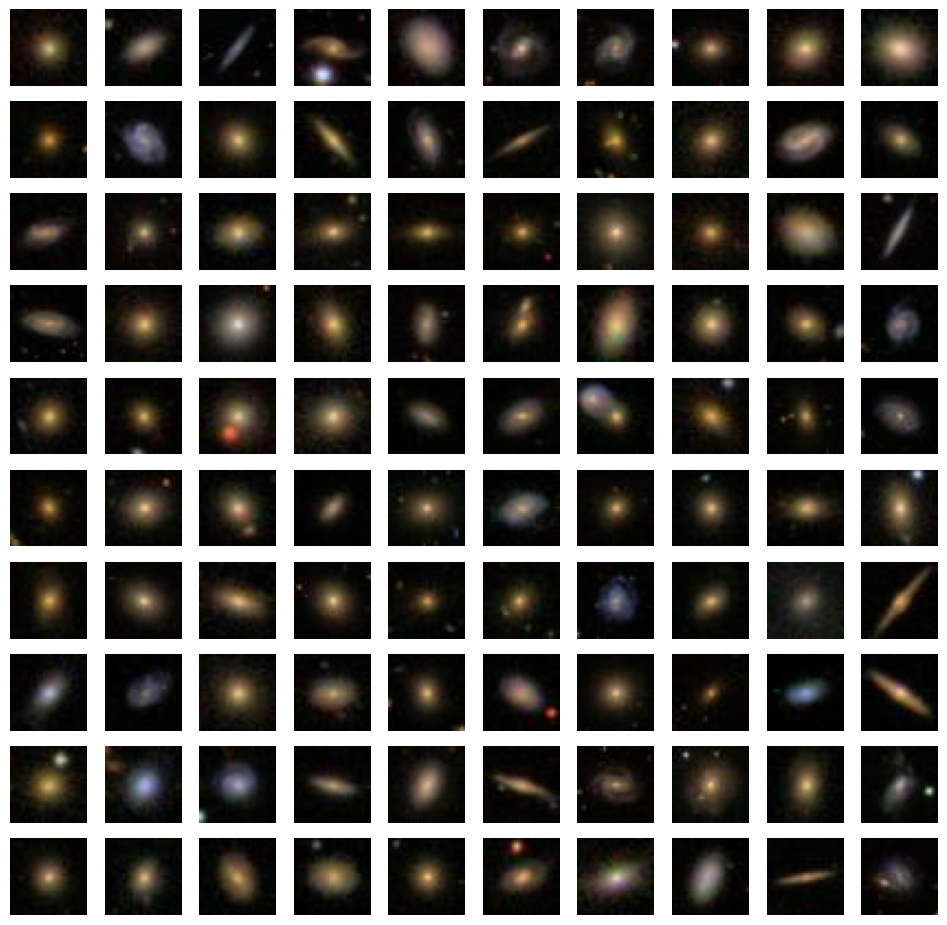

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(12, 12), dpi=100)

for i in range(100):
    PILImage.create(lowres_image_files[100+i]).show(figsize=(5,5), ax=axes.flat[i])

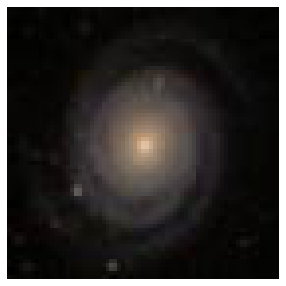

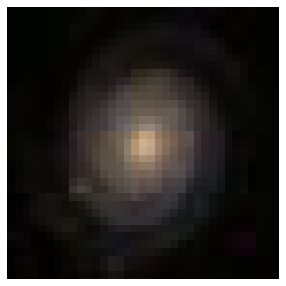

In [ ]:
idx = 38
PILImage.create(original_image_files[idx]).show(figsize=(5,5))
PILImage.create(lowres_image_files[idx]).show(figsize=(5,5))

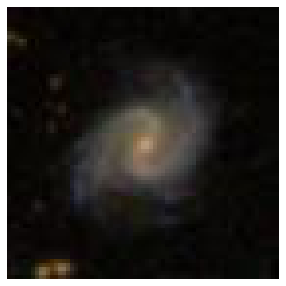

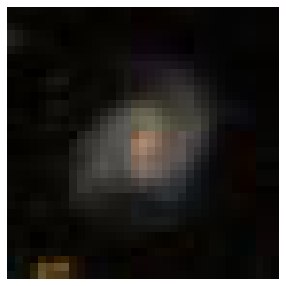

In [ ]:
idx = 106
PILImage.create(original_image_files[idx]).show(figsize=(5,5))
PILImage.create(lowres_image_files[idx]).show(figsize=(5,5))

# Training unet generator

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, ImageBlock),
    get_items=get_image_files,
    get_y = lambda x: f'original/{x.name}',
    splitter=RandomSplitter(),
    item_tfms=Resize(69),
    batch_tfms=[*aug_transforms(flip_vert=True, max_zoom=1., p_lighting=0, max_warp=0), Normalize]
)

In [ ]:
dls = dblock.dataloaders('./lowres', bs=128)
xb = first(dls.train)[0]
xb.mean((0, 2, 3)), xb.std((0, 2, 3))

(TensorImage([-0.0365, -0.0362, -0.0041], device='cuda:0'),
 TensorImage([0.9622, 0.9673, 1.0247], device='cuda:0'))

In [ ]:
stats = [[-0.0365, -0.0362, -0.0041], [0.9622, 0.9673, 1.0247]]

In [ ]:
def get_dls(bs:int, size:int, stats=stats):
    "Generates two `GAN` DataLoaders"
    dblock = DataBlock(
        blocks=(ImageBlock, ImageBlock),
        get_items=get_image_files,
        get_y = lambda x: f'./original/{x.name}',
        splitter=RandomSplitter(),
        item_tfms=Resize(69),
        batch_tfms=[*aug_transforms(flip_vert=True, max_zoom=1., p_lighting=0), Normalize.from_stats(*stats)]
    )
    dls = dblock.dataloaders('./lowres', bs=bs)
    dls.c = 3
    return dls

In [ ]:
dls_gen = get_dls(bs=64, size=69)

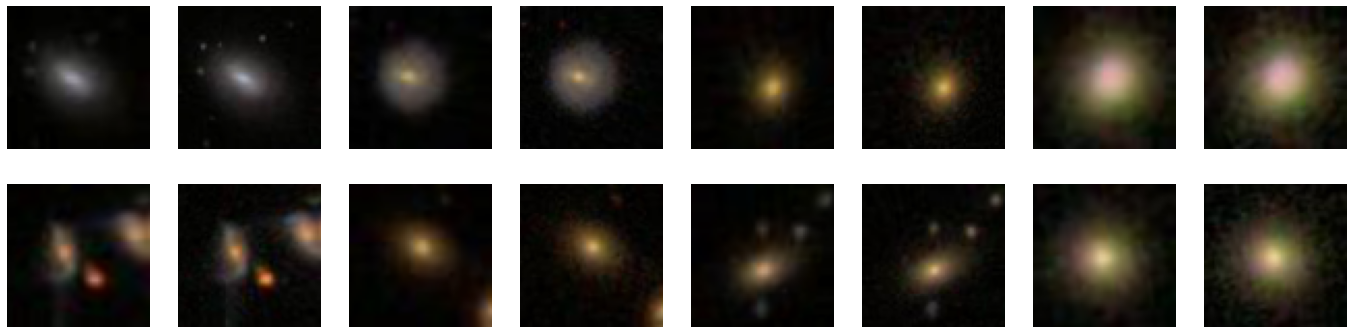

In [ ]:
dls_gen.show_batch(max_n=8)

In [ ]:
def create_gen_learner():
    return unet_learner(
    dls_gen,
    resnet18,
    pretrained=True,
    loss_func=MSELossFlat(),
    blur=True,
    norm_type=NormType.Weight,
    self_attention=True,
)
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# use imagenet-pretrained on resnet18
learn_gen = unet_learner(
    dls_gen,
    resnet18,
    pretrained=True,
    loss_func=MSELossFlat(),
    blur=True,
    norm_type=NormType.Weight,
    self_attention=True,
)

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=1.4454397387453355e-05)

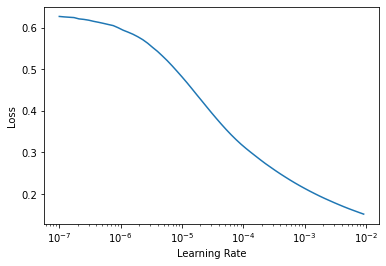

In [ ]:
learn_gen.lr_find()

In [ ]:
learn_gen.fit_one_cycle(2, 0.001, pct_start=0.8, wd=0.001)

epoch,train_loss,valid_loss,time
0,0.001078,0.000634,01:14
1,0.000340,0.000348,01:13


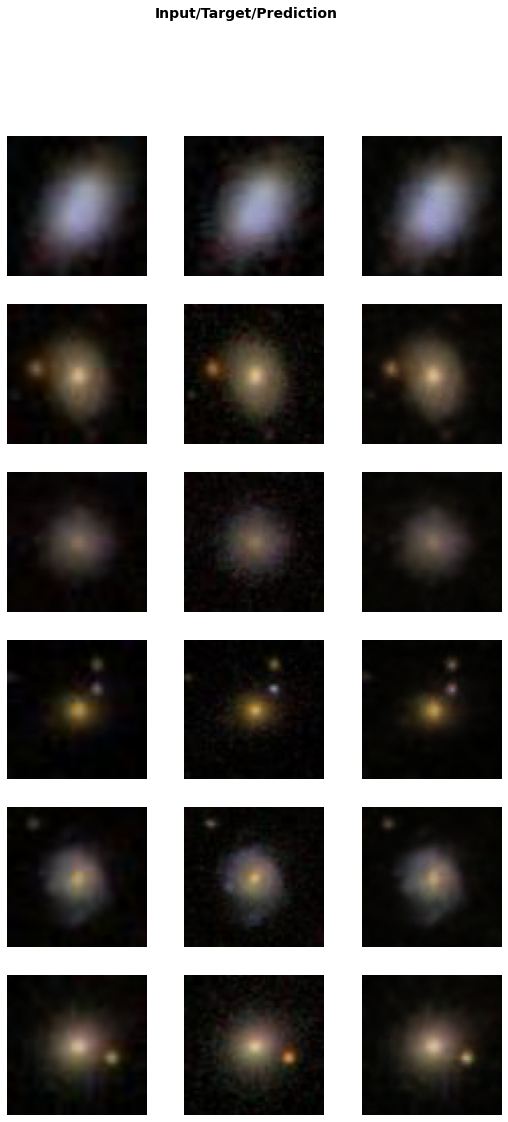

In [ ]:
learn_gen.show_results(max_n=12)

In [ ]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3), wd=0.001)

epoch,train_loss,valid_loss,time
0,0.000277,0.000305,01:16
1,0.000243,0.000289,01:17
2,0.000231,0.000283,01:17


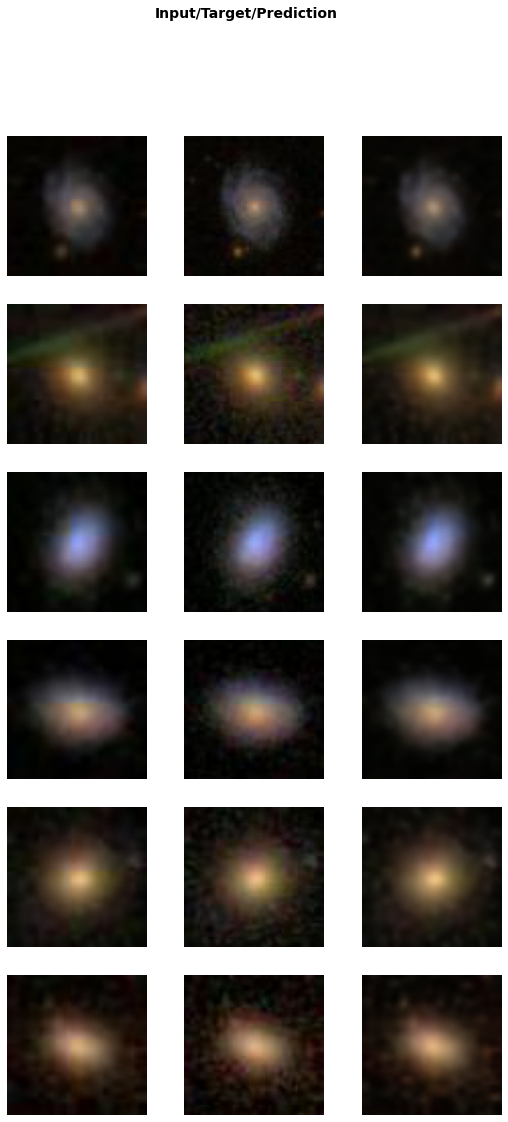

In [ ]:
learn_gen.show_results(max_n=12)

In [ ]:
learn_gen.save('gen-pre')
learn_gen.load('gen-pre')

# Save generated images

In [ ]:
!mkdir image_gen

In [ ]:
def save_preds(dl, learn):
  "Save away predictions"
  names = dl.dataset.items

  preds,_ = learn.get_preds(dl=dl)
  for i,pred in enumerate(preds):
      dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
      arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
      Image.fromarray(arr).save(f'./image_gen/{names[i].name}')

In [ ]:
dl = dls_gen.train.new(
    shuffle=False,
    drop_last=False,
    after_batch=[IntToFloatTensor, Normalize.from_stats(*stats)]
)

In [ ]:
save_preds(dl, learn_gen)

In [ ]:
import gc; gc.collect()

102636

In [ ]:
def get_crit_dls(fnames, bs:int, size:int):
    "Generate two `Critic` DataLoaders"
    splits = RandomSplitter(0.1)(fnames)
    dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                    splits=splits)
    tfms = [ToTensor(), Resize(size)]
    gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*stats)]
    return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [ ]:
generated_image_files = get_image_files('./image_gen')

In [ ]:
dls_crit = get_crit_dls(generated_image_files + original_image_files, bs=64, size=69)

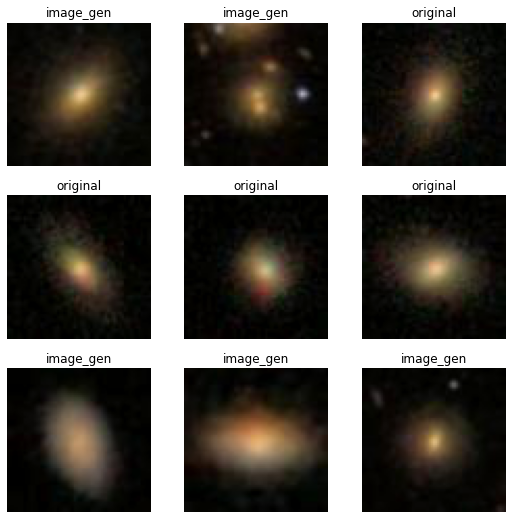

In [ ]:
dls_crit.show_batch()

In [ ]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
def create_crit_learner(dls, metrics):
  return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [ ]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=0.0014454397605732083)

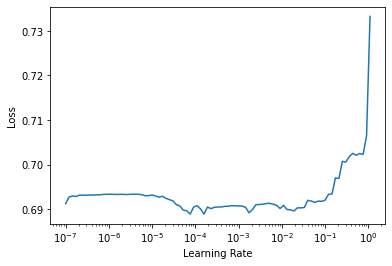

In [ ]:
learn_crit.lr_find()

In [ ]:
learn_crit.fit_one_cycle(3, 1e-3, wd=1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.220353,0.194274,0.922698,03:44
1,0.090253,0.075311,0.970953,03:55
2,0.059195,0.049481,0.982197,03:57


In [ ]:
learn_crit.save('critic-pre')

Path('models/critic-pre2.pth')

# The GAN

In [ ]:
fnames = generated_image_files + original_image_files
ls_crit = get_crit_dls(fnames, bs=64, size=69)

In [ ]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('critic-pre')

In [ ]:
learn_gen = create_gen_learner().load('gen-pre')

See https://colab.research.google.com/github/walkwithfastai/walkwithfastai.github.io/blob/master/nbs/course2020/vision/07_Super_Resolution.ipynb#scrollTo=PaBcYB8oESLP&line=12&uniqifier=1

In [ ]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training:
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [ ]:
# GAN switcher callback
switcher = AdaptiveGANSwitcher(critic_thresh=0.6)

In [ ]:
gc.collect()

132789

In [ ]:
learn = GANLearner.from_learners(
    learn_gen,
    learn_crit,
    weights_gen=(1., 100.),
    show_img=False,
    switcher=switcher,
    opt_func=partial(ranger, mom=0),
    cbs=GANDiscriminativeLR(mult_lr=5.)
)

In [ ]:
lr = 1e-4
learn.fit(10, lr, wd=0.001)

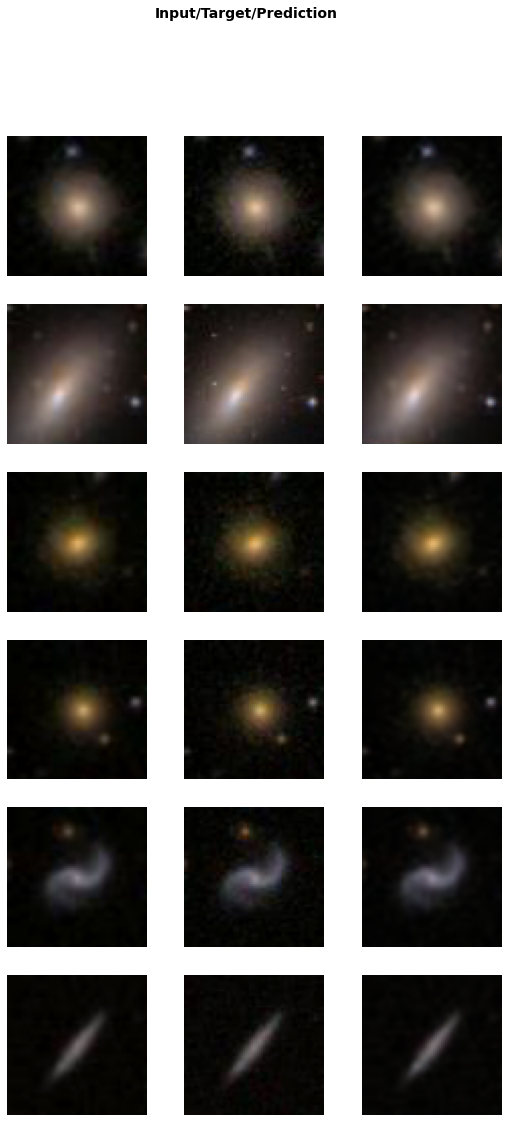

In [ ]:
learn.show_results(max_n=12)